## Requirements

In [53]:
%pip install scikit-learn mlxtend librosa xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [54]:
import pandas as pd
import numpy as np
import itertools
import librosa

from sklearn.datasets import fetch_openml
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, cross_val_score, cross_val_predict, RandomizedSearchCV, GridSearchCV, cross_validate, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.decomposition import PCA
from scipy.stats import loguniform, beta, uniform

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as IMBPipeline

from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier # for multiclass classification

import matplotlib.pyplot as plt
import matplotlib as mlp

# Timbre classification problem
In this project I will try to use machine learning algorithms to classify the timbre of 19 selected instruments. I will use [this dataset](https://philharmonia.co.uk/resources/sound-samples/), containing the sample recordings of the 19 different instruments playing different notes with different dynamics and different tecniques. I will construct a spectrogram and keep as data the $129 \times 9$ spectrogram obtained by analising the first 9192 samples of the recording (about 0.2 seconds), discretizing the time in 9 intervals and the frequency in 129 intervals.

## Preprocessing

In [114]:
def show_spectrogram(spec):
    spec = spec.reshape(129, 9)
    librosa.display.specshow(spec, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')

### Transforming the audio files into a usable format
In order to utilize the dataset, we will transform the audios into a more usable format, namely a spectrogram. I will show the process applied to just one of the audio files in order to explain it, but the full code is found in the `create_dataset.py` script, and its ouput is the file used in next chapters, `data/timbre_data.csv`. There is also a `data/timbre_data400ms.csv` that, as the name suggests is the same analysis as presented here and used in this classification project, but where the data analysed is 0.4s instead of 0.2s

In [262]:
LEN_SAMPLE = 9192 # audio is sampled at 44100 Hz, so this is a little more then 0.2s
y, sr = librosa.load("data/all-samples/viola_A5_05_pianissimo_arco-normal.mp3", sr=44100)

First we add an energy threshold, meaning we cut the audio so that it starts when it has reached 90% of the maximum root mean squared value of the intensity of the sample. We will use `librosa.feature.rms`

In [263]:
rms = librosa.feature.rms(y=y) # Energy threshold
start = np.argmax(rms/rms.max() > .9) * len(y) // len(rms[0])
end = len(y) - np.argmax(rms[::-1] > 0.1 * len(y)) // len(rms[0])
y = y[start:start+LEN_SAMPLE]
assert len(y) >= LEN_SAMPLE, f"Sample too short, smaller than {LEN_SAMPLE/44100:.2f}s"

The last line is needed since some of the files will result in a useful audio shorter than 0.2s, so we will remove from the dataset those files, as they would give us a spectrogram of wrong dimensions. Moreover, such files are only a small percentage of the whole dataset, so it's not a problem to remove them.

Now we can compute the spectrometer

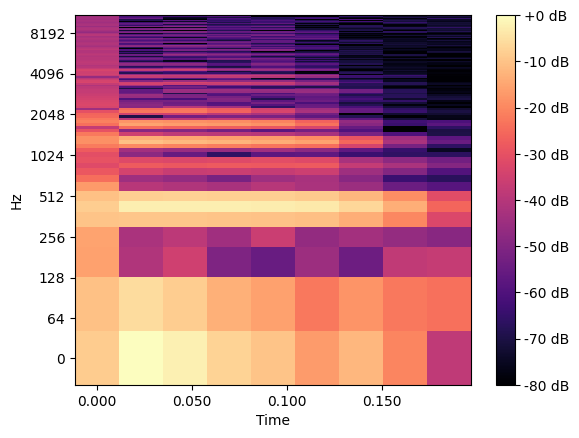

In [264]:
n_fft = 256 # no. frequency bins = n_fft/2 + 1 = 129
hop_length = (LEN_SAMPLE-n_fft)//8 # no. frames = ceil((LEN_SAMPLE - n_fft)/8) + 1 = 9
spec = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length)) # computes short time fourier transform
spec = librosa.amplitude_to_db(spec, ref=np.max)
show_spectrogram(spec)

Where here `n_fft` and `hop_length` are chosen in order to get a low quality spectrogram which still keeps a lot of information. In particular `spec` is now a $9 \times 129$ spectrogram

In file `create_dataset.py`, this same procedure is then applied to all 13535 files in the original dataset and the output is saved in file `data/timbre_data.csv`, 13318 recordings were kept and 217 discarded

### Dataset importing
We now import the previously calculated spectrograms

In [5]:
timbre = pd.read_csv('data/timbre_data.csv')
timbre_label = timbre['1161']
timbre_data = timbre.drop('1161', axis=1)

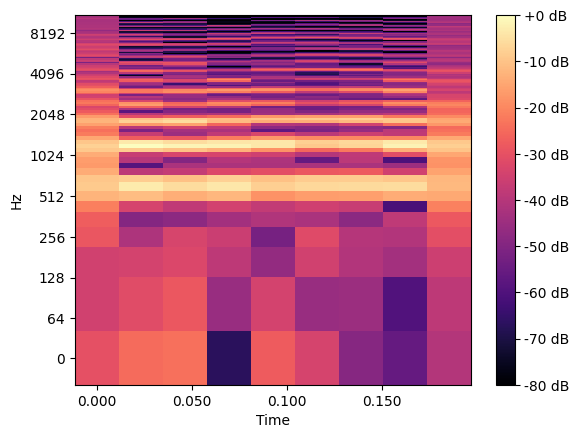

In [6]:
show_spectrogram(np.array(timbre_data)[7120])

### Data transformation
All of the data contained in our dataset consists in decibels. We will standardize them all by applying the `StandardScaler`. We won't do any further modification to the data as we know there are no missing values (we already managed the problem while creating the database)

In [265]:
final_transformation = StandardScaler()

### Dataset splitting
We split the dataset from training and testing, leaving 20% of the dataset for the testing.

In [8]:
X, y = timbre_data, timbre_label
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=75)
classes = y.value_counts().keys().values # The array of all classes, useful later
y.value_counts()

1161
violin           1499
tuba              963
viola             948
bass-clarinet     941
cello             884
double-bass       850
clarinet          846
trombone          831
flute             790
contrabassoon     710
saxophone         693
english-horn      691
bassoon           686
french-horn       652
oboe              589
trumpet           485
guitar            106
mandolin           80
banjo              74
Name: count, dtype: int64

We immediately see we will have to manage class imbalance, since every class has different number of recordings, and the number varies largely

## Model Selection
We will have different options for the model:
- dimension reduction (at the moment we have 1161 features, since the spectrograms are 129 x 9)
- handling imbalanced classes
- classification (`OneVsOneClassifier` or `OneVsRestClassifier`)
    - Within classification, we will have to find a good estimator

Let's start by defining a starting model of pipeline.

In [101]:
model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('sampler', SMOTE()),
    ('dim_reduction', PCA(n_components=0.8)),
    ('classifier', OneVsOneClassifier(KNeighborsClassifier(n_neighbors=7, algorithm='kd_tree')))
])

As a sanity check, I will run the `fit` and `predict` methods to check for eventual errors

In [102]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('all', StandardScaler(),
                                                  Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '1151', '1152', '1153', '1154', '1155', '1156', '1157', '1158', '1159',
       '1160'],
      dtype='object', length=1161))],
                                   verbose_feature_names_out=False)),
                ('sampler', SMOTE()), ('dim_reduction', PCA(n_components=0.8)),
                ('classifier',
                 OneVsOneClassifier(estimator=KNeighborsClassifier(algorithm='kd_tree',
                                                                   n_neighbors=7)))])

In [103]:
dec_values = model_pipeline.decision_function(X_test[:5])
predicted = model_pipeline.predict(X_test[:5])
correct = y_test[:5].values

print("\n".join([f"Prediction: {predicted[i]:<13} {dec_values[i][np.where(model_pipeline.classes_ == predicted[i])][0]:.2f}% \
       \tCorrect: {correct[i]:<13} {dec_values[i][np.where(model_pipeline.classes_ == correct[i])][0]:.2f}%" for i in range(5)]))

Prediction: bassoon       18.12%        	Correct: bassoon       18.12%
Prediction: bass-clarinet 17.88%        	Correct: viola         15.31%
Prediction: oboe          18.31%        	Correct: oboe          18.31%
Prediction: violin        18.32%        	Correct: violin        18.32%
Prediction: banjo         17.85%        	Correct: clarinet      17.24%


Since we didn't get any errors and everything went smoothly, we will try again and test different combinations of classification models, using different tecniques in order to find the method (in particular choosing the best estimator for the `OneVsOneClassifier` or `OneVsRestClassifier`)

In [52]:
sampler_configs = [
    {
        'sampler':[None],# The element is bypassed
    },
    {
        'sampler':[SMOTE()],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    },
    {
        'sampler':[RandomOverSampler()],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    }
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': ['mle', 0.1, 0.5, 0.9]
    },
    {
        'dim_reduction': [LDA()]
    },
    {
        'dim_reduction': [SFS(estimator=Perceptron(), cv = None, scoring = 'balanced_accuracy')],
        'dim_reduction__estimator': [Perceptron(), LogisticRegression()],
        'dim_reduction__k_features' : [5,7,10]  
    }
]

classifier_configs = [
    {
        'classifier': [OneVsOneClassifier(estimator=GaussianProcessClassifier(multi_class="one_vs_one")), OneVsRestClassifier(estimator=GaussianProcessClassifier(multi_class="one_vs_rest"))],
        'classifier__estimator': [None, # Gaussian Process
                                  Perceptron(),
                                  LogisticRegression(multi_class="multinomial"),
                                  # LogisticRegressionCV(multi_class="multinomial"),
                                  KNeighborsClassifier(n_neighbors=7, algorithm='kd_tree'),
                                 ]
    },
    # {
    #     'classifier': [RandomForestClassifier(), XGBClassifier(device="cuda")],
    # },
]

In [105]:
all_configs = [dict(itertools.chain(*(e.items() 
for e in configuration))) 
for configuration in
itertools.product(sampler_configs,dim_reduction_configs,classifier_configs)]

In [106]:
print(f'Number of all possible configurations: {len(all_configs)}')
all_configs[10]

Number of all possible configurations: 12


{'sampler': [RandomOverSampler()],
 'sampler__sampling_strategy': ['minority', 1.2, 0.9, 0.7],
 'dim_reduction': [LinearDiscriminantAnalysis()],
 'classifier': [OneVsOneClassifier(estimator=GaussianProcessClassifier(multi_class='one_vs_one')),
  OneVsRestClassifier(estimator=GaussianProcessClassifier())],
 'classifier__estimator': [None,
  Perceptron(),
  LogisticRegression(multi_class='multinomial'),
  KNeighborsClassifier(algorithm='kd_tree', n_neighbors=7)]}

In [107]:
rs = RandomizedSearchCV(model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs) * 5,
    n_jobs=-1,
    cv = 2,
    scoring='balanced_accuracy'
)

In [108]:
scores = cross_validate(rs, X_train, y_train, scoring='balanced_accuracy', cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=2), return_estimator=True, verbose=10) # about 6 hours

[CV] START .....................................................................
[CV] END ......................................., score=0.791 total time=37.8min
[CV] START .....................................................................
[CV] END ......................................., score=0.781 total time=30.8min
[CV] START .....................................................................
[CV] END ......................................., score=0.748 total time=40.4min
[CV] START .....................................................................
[CV] END ......................................., score=0.801 total time=58.9min
[CV] START .....................................................................
[CV] END ......................................., score=0.778 total time=39.6min
[CV] START .....................................................................
[CV] END ......................................., score=0.609 total time=25.6min
[CV] START .................

In [111]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

SMOTE(sampling_strategy='minority')
None
OneVsOneClassifier(estimator=Perceptron()) {'estimator__alpha': 0.0001, 'estimator__class_weight': None, 'estimator__early_stopping': False, 'estimator__eta0': 1.0, 'estimator__fit_intercept': True, 'estimator__l1_ratio': 0.15, 'estimator__max_iter': 1000, 'estimator__n_iter_no_change': 5, 'estimator__n_jobs': None, 'estimator__penalty': None, 'estimator__random_state': 0, 'estimator__shuffle': True, 'estimator__tol': 0.001, 'estimator__validation_fraction': 0.1, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': Perceptron(), 'n_jobs': None}
0.7914408220020878
----------
None
PCA(n_components='mle')
OneVsOneClassifier(estimator=Perceptron()) {'estimator__alpha': 0.0001, 'estimator__class_weight': None, 'estimator__early_stopping': False, 'estimator__eta0': 1.0, 'estimator__fit_intercept': True, 'estimator__l1_ratio': 0.15, 'estimator__max_iter': 1000, 'estimator__n_iter_no_change': 5, 'estimator__n_jobs': None, 'estimator__pe

In [112]:
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    acc_train = balanced_accuracy_score(y_train, pred_train)
    acc_test = balanced_accuracy_score(y_test, pred_test)
    print(f'Balanced accuracy on training set:{acc_train}, Balanced accuracy on test set:{acc_test}')

Accuracy on training set:0.9887676453706792, Accuracy on test set:0.7961802315630138
Accuracy on training set:0.988671777285165, Accuracy on test set:0.7894722852265844
Accuracy on training set:0.9259672756532679, Accuracy on test set:0.8119718970586212
Accuracy on training set:0.9997749246409885, Accuracy on test set:0.8363861242629596
Accuracy on training set:0.8968966476865647, Accuracy on test set:0.7755115389394076
Accuracy on training set:0.6914997008240656, Accuracy on test set:0.6079630677406308
Accuracy on training set:0.9934865681049551, Accuracy on test set:0.7240520402807864
Accuracy on training set:0.9938117129810203, Accuracy on test set:0.7266132775385783


### Refinement of the selected model
We will now take one of the best performing models from before and search for the best hyperparameter configuration. We will use the One Vs One Classifier with Perceptron, with the `RandomOverSampler` and PCA such that it explains 90% of the original variance. Even though the best performing model was tecnically the one with `PCA(n_components='mle')`, which implements Minka's MLE algorithm to guess the dimension, since the latter is extremely well performing on known data we will discard it since it seams to bring too much overfitting. Moreover, being simpler to handle in calculations, it will be computationally easier to manage the Perceptron estimator

In [126]:
best_model_pipeline = scores['estimator'][2].best_estimator_
best_model_pipeline

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('all', StandardScaler(),
                                                  Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '1151', '1152', '1153', '1154', '1155', '1156', '1157', '1158', '1159',
       '1160'],
      dtype='object', length=1161))],
                                   verbose_feature_names_out=False)),
                ('sampler', RandomOverSampler(sampling_strategy='minority')),
                ('dim_reduction', PCA(n_components=0.9)),
                ('classifier', OneVsOneClassifier(estimator=Perceptron()))])

Now we will use Randomized Search again to fine tune the model and search for the best hyperparameters

In [150]:
param_grid = {
    'classifier__estimator__alpha': loguniform(0.0001, 1),  # Regularization strength
    'classifier__estimator__max_iter': [10, 50],  # Maximum number of passes over the training data
    'classifier__estimator__eta0': loguniform(0.001, 0.1),  # Initial learning rate
}

In [153]:
rs_best = RandomizedSearchCV(
    estimator = best_model_pipeline,
    param_distributions = param_grid,
    cv = StratifiedKFold(n_splits=5),
    n_jobs=-1,
    verbose=1,
    scoring="balanced_accuracy",
)
# rs_best = GridSearchCV(best_model_pipeline,
#                        param_grid,
#                        cv=StratifiedKFold(n_splits=5),
#                        scoring='balanced_accuracy',
#                        n_jobs=-1,
#                        verbose=10)

In [154]:
rs_best.fit(X_train, y_train) # a lot of time

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('trans',
                                              ColumnTransformer(transformers=[('all',
                                                                               StandardScaler(),
                                                                               Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '1151', '1152', '1153', '1154', '1155', '1156', '1157', '1158', '1159',
       '1160'],
      dtype='object', length=1161))],
                                                                verbose_feature_names_out=...
                                              OneVsOneClassifier(estimator=Perceptron()))]),
                   n_jobs=-1,
                   param_distributions={'classifier__estimator__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fcbb9e03150>,
                                        'classifier__estimator__eta0': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fcbc2a8f0d0>,
                                        'classifier__estimator__max_iter': [10,
                                                                            50]},
                   scoring='balanced_accuracy', verbose=1)

In [155]:
cls = rs_best.best_estimator_
cls.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('all', StandardScaler(),
                                                  Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '1151', '1152', '1153', '1154', '1155', '1156', '1157', '1158', '1159',
       '1160'],
      dtype='object', length=1161))],
                                   verbose_feature_names_out=False)),
                ('sampler', RandomOverSampler(sampling_strategy='minority')),
                ('dim_reduction', PCA(n_components=0.9)),
                ('classifier',
                 OneVsOneClassifier(estimator=Perceptron(alpha=0.12659752082516978,
                                                         eta0=0.07335931669218297,
                                                         max_iter=50)))])

In [160]:
f'Balanced accuracy on training set: {balanced_accuracy_score(y_train, cls.predict(X_train))}, Balanced accuracy on test set: {balanced_accuracy_score(y_test, cls.predict(X_test))}'

'Balanced accuracy on training set: 0.9218297809773097, Balanced accuracy on test set: 0.8027001069766372'

The difference in accuracy between the training and test set is very different, so it must be the case that our model still suffers from overfitting. **However** there's one thing to note: our dataset contains different instrument playing different notes, at different dynamics and _with different tecniques_, for example for the violin, we have both _arco_ and _pizzicato_, so it might be that the model doesn't recognize easily instruments that are similar in sound with certain tecniques, like mandolin, banjo and _pizzicato_ on the bowed string instruments 

### Learning curve
In this step we will construct the learning curve, in order to visualize the bias/variance trade-off as a function of the size of the training set

In [249]:
train_sizes_lc, train_scores_lc, test_scores_lc = learning_curve(cls,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 5,
                                                       n_jobs = -1,
                                                       scoring = 'balanced_accuracy',
                                                       shuffle = False)

/home/oxke/.virtualenvs/MLTimbre/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/oxke/.virtualenvs/MLTimbre/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


(0.6, 1.0)

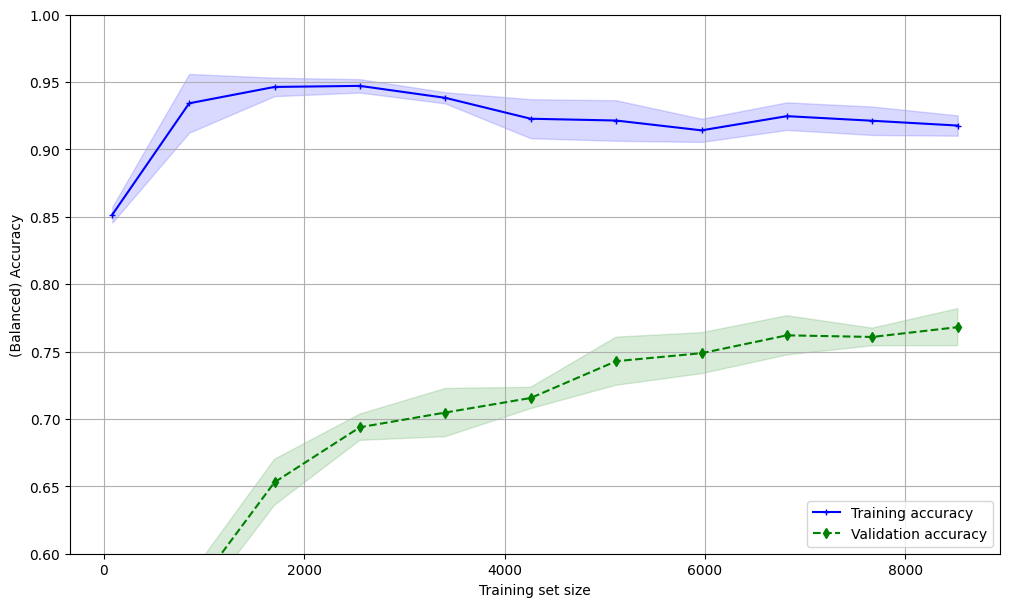

In [250]:
train_mean = np.mean(train_scores_lc, axis=1)
train_std = np.std(train_scores_lc, axis=1)
test_mean = np.mean(test_scores_lc, axis=1)
test_std = np.std(test_scores_lc, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('(Balanced) Accuracy')
ax.legend(loc='lower right')
ax.set_ylim([0.6, 1])

This learning curve shows the presence of high variance in the model. This means the model suffers from overfitting and it's modeling the random noise in the data instead

### Validation Curve
In this step we will construct the learning curve, in order to visualize the bias/variance trade-off as a function of $\alpha$, hyperparameter of the `Perceptron` estimator for the `OneVsOneClassifier`

In [251]:
range_alpha = [0.0001,0.0005, 0.0025, 0.0625, 0.3125, 1.5625]
train_scores_vc, test_scores_vc = validation_curve(cls,
        X=X_train, 
        y=y_train,
        param_range= range_alpha, 
        param_name='classifier__estimator__alpha',
        cv=5, 
        n_jobs=-1, 
        scoring='balanced_accuracy'
)

/home/oxke/.virtualenvs/MLTimbre/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


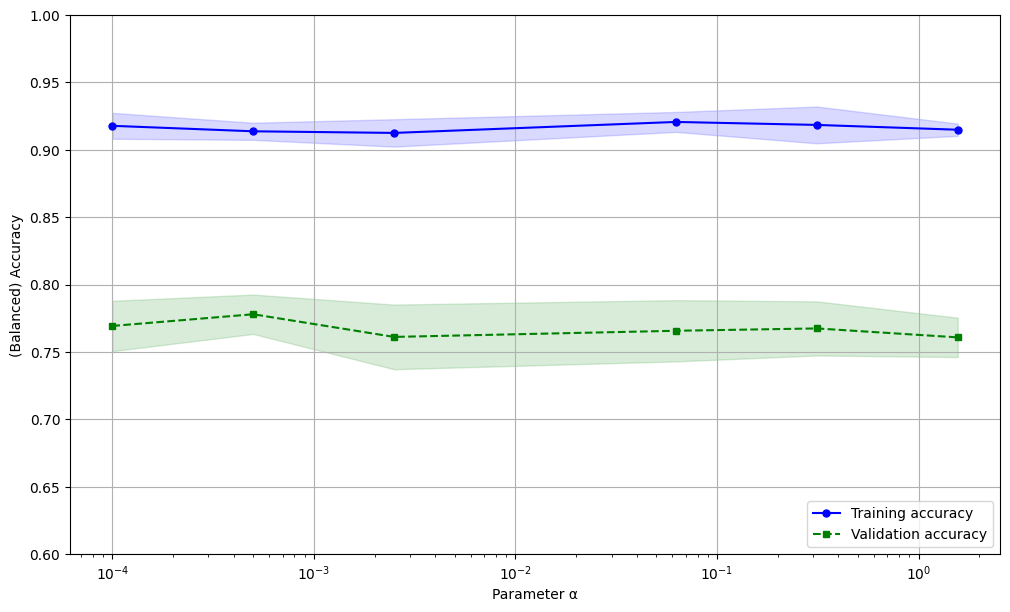

In [252]:
train_mean = np.mean(train_scores_vc, axis=1)
train_std = np.std(train_scores_vc, axis=1)
test_mean = np.mean(test_scores_vc, axis=1)
test_std = np.std(test_scores_vc, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_alpha, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_alpha,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_alpha, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_alpha,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Parameter α')
ax.set_ylabel('(Balanced) Accuracy')
ax.legend(loc='lower right')
ax.set_ylim([0.6, 1])
ax.set_xscale('log')

Changing the parameter `\alpha` thus does not solve the overfitting problem

## Error analysis

Let's try to analyze the confusion matrix for our problem. We have to inspect a $19\times 19$ matrix, which represents the accuracy of our model. On the vertical axis we will have the correct instruments, and on the horizontal one we will have the predicted ones. I will set to 0 the diagonal, so that we can see in more detail where the models got errors, since in theory (in case of 100% accuracy) we would find that the diagonal is made of only ones and all the other values are zeros. Obviously this isn't the case, but we can focus on the mistakes and understand the model and dataset better.

In [246]:
y_test_predicted = cross_val_predict(cls, X_test, y_test, cv = 4)
conf_matrix = confusion_matrix(y_test,
                               y_test_predicted,
                               labels=classes,
                               normalize='true') # normalizes on rows

Now we can plot the results and analyse them, after having set the diagonal of the matrix to zeros

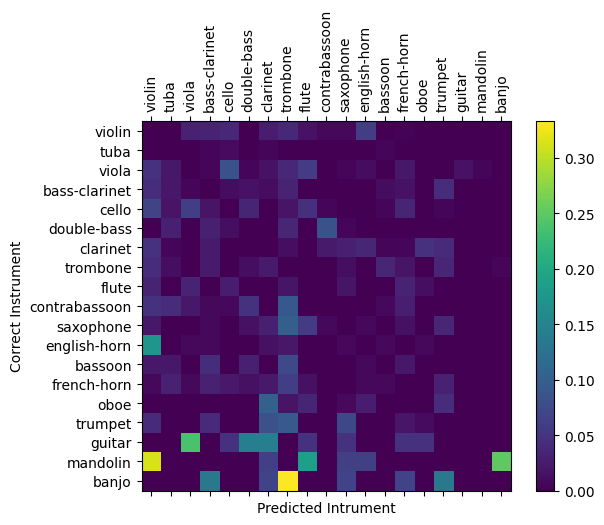

In [248]:
fig = plt.figure()
ax = fig.add_subplot(111)
conf_matrix_without_diagonal = conf_matrix - np.diag(conf_matrix.diagonal())
cax = ax.matshow(conf_matrix_without_diagonal)
fig.colorbar(cax)

ax.set_xticks(np.arange(19),labels=classes, rotation='vertical')
ax.set_yticks(np.arange(19),labels=classes)

ax.set_xlabel("Predicted Intrument")
ax.set_ylabel("Correct Instrument")
plt.show()

We see the most difficult instrument to recognize are the ones with the least samples in the dataset. This probem could be solved by extending the dataset and trying to manage the class imbalance in other ways then just using balanced accuracy as the metric for the loss functions. Another possibility is to change the way the data is represented: at the cost of a much higher resources usage, we could have a more detailed spectrogram, for example by using a longer bit of audio, in order to analyse more then 0.2 seconds for each recordings, and have more detail in the frequencies, instead of binning it to just 129 ranges. However, this would hugely impact the computational cost. 

Finally. It could be the case that analysing and storing the audio files in different ways might give better results (ex. performing some kind of cleaning from noise and adding a low and high frequency cut in order to limit our knowledge to the useful data)

# Appendix
Here I will report the code of the `create_dataset.py` file and explain some of the tries that didn't make it into this file.

### `Create_dataset.py` code

```python
#!/usr/bin/env python
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob

sample_rate = 44100
LEN_SAMPLE = 9192

timbre_data = []

audio_files = glob.glob("data/all-samples/*.mp3")
for i, f in enumerate(audio_files):
    print(f"\rProcessing file {i+1}/{len(audio_files)} (actually/{len(audio_files) - (i+1 - len(timbre_data))}): Loading ...", end='')
    try:
        y, sr = librosa.load(f, sr=sample_rate)
    except Exception as e:
        print(f"error {e}, continuing...")
        continue
    instrument = f.split('_')[0].split('/')[-1]
    
    rms = librosa.feature.rms(y=y) # Energy threshold
    start = np.argmax(rms/rms.max() > .9) * len(y) // len(rms[0])
    end = len(y) - np.argmax(rms[::-1] > 0.1 * len(y)) // len(rms[0])
    y = y[start:start+LEN_SAMPLE]
    if len(y) < LEN_SAMPLE:
        print(f"File {f} skipped, too short")
        continue

    print("DONE, Computing spectrometer ...", end='')
    n_fft = 256
    hop_length = (LEN_SAMPLE - n_fft)//8
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    spec = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    spec = librosa.amplitude_to_db(spec, ref=np.max)

    # Saving the whole spectogram
    timbre_data.append([*spec.reshape(spec.shape[0] * spec.shape[1]), instrument])

df_timbre = pd.DataFrame(timbre_data)
df_timbre.to_csv("data/timbre_data_400ms.csv", index=False)
```

## Discarded ideas
### Peak frequencies
My first idea was actually to try and extract from the audio the frequency and intensities of the peak frequencies contained in each frame of the spectrogram. This turned out to be a bad idea since:
- It introduced a lot more noise (since if there were noise in the audio which was louder than useful sound - i.e. white sounds in stringed instruments playing pianissimo - then the algorithm registered such low frequencies as more important
    - solution: introduced the low frequency cut, which reduced the intensities of the frequency $(0, f/4]$ Hz , where $f$ is the frequency of the note played in the audio, which I could know from the audio name
- Usually musical instruments don't play perfect frequencies and armonics with perfect precision, i.e. the fundamental takes often a wider range than it should, and it is more the case when the analysis is done with the stft on a very short time.
### 0.4s
At first I started analysing the first 0.4s, then I decided to lower it to 0.2 since I could keep a larger number of recordings (13318 instead of 10902). Then I realized I could have calculated the time frames better and on later attempts I used a `LEN_SAMPLE` of 17640 which equates to exactly 0.4s and a total number of useful recordings of 11223, though it was only slightly better than this one, so I preferred to don't change back to 0.4s but keep it like it is here.
### Different Models and Estimators for the OvO and OvR classifiers
I had tried using different models before like one can see by looking at the params configuration dictionary in Model Selection. I decided to remove them though, since it was too computationally resourceful. I also tried using different models which implemented bagging, adaptive boosting and gradient boosting, in order to limit overfitting (in particular `XGBoost`) which didn't have exceptionally better results than thouse shown in this notebook and were also very resourceful to optimize and fine-tune, so I ended up removing all of that part from the project since 1. I could not finish fine-tuning in time and 2. It showed extreme overfitting (99.97% accuracy on training data and 83% on new data)